# LOFAR single station imaging

Based on version 1.4 of V.A. Moss's tutorial, tutorial from M.A. Brentjens 8/8/2017.

Updated February 2020 by T.J. Dijkema with aerial imagery backdrops.

In [1]:
import os
import sys
import time
import datetime
import glob
import numpy as np

from scipy import ndimage

from lofarantpos.db import LofarAntennaDatabase

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

In [3]:
# We need lofarantpos >= 0.4.0 to get the station rotations

from packaging import version
import lofarantpos
assert(version.parse(lofarantpos.__version__) >= version.parse("0.4.0"))

In [4]:
from lofarimaging import find_caltable, sb_from_freq, freq_from_sb, read_caltable, \
    read_acm_cube, get_background_image, sky_imager, ground_imager

In [5]:
# We need python 3.6 for f-string formatting

assert(sys.version_info.major + 0.1*sys.version_info.minor >= 3.6)

In [6]:
data_dir = "./"
config_dir = "./caltables"  # Root directory under which station information is stored in subdirectories DE602C/etc/, RS106/etc/, ...
station = 'DE603LBA'
stype = 'intl'

In [7]:
start1 = time.time()

In [8]:
# Read all available .dat files
print(f"Searching for available files in {data_dir}")
files = glob.glob(data_dir + "/*.dat")
for file_index, filename in enumerate(files):
    print(f"{file_index}: {filename}")

Searching for available files in ./
0: ./20170720_095816_mode_3_xst_sb297.dat


In [9]:
# Select a file
cubefile = files[0]

print("File selected:", cubefile)

File selected: ./20170720_095816_mode_3_xst_sb297.dat


In [10]:
# Initialisation parameters
# Modified to match output from M. Mancini script
cubename = os.path.basename(cubefile)

# Make directory for results
# Note... this won't work for windows...
try:
    os.mkdir('results')
except FileExistsError:
    print("results directory already exists...\n")

# Distill metadata from filename
obsdatestr, obstime, _, stationtype, _, subbandname = cubename.rstrip(".dat").split("_")
subband = int(subbandname[2:])
    
# Needed for NL stations: inner (mode 3/4), outer (mode 1/2), (sparse tbd)
# Should be set to 'inner' if station type = 'intl'
if stationtype in ('1', '2'):
    atype == 'outer'
elif stationtype in ('3', '4'):
    atype = 'inner'
else:
    raise Exception("Unexpected mode: ", stationtype)

# Get the data
fname = f"{obsdatestr}_{obstime}_{station}_SB{subband}"

npix_l, npix_m = 101, 101
freq = freq_from_sb(subband)

# Which slice in time to visualise
timestep = 0

# Calculate start time
starttime = datetime.datetime.strptime(obstime, '%H%M%S')

# For ground imaging
extent = np.array([-150, 150, -150, 150]) # metres in the localnorth frame (relative to station phase center)
height = 1.5 # metres
ground_resolution = 0.5 # pixels per metre for ground_imaging, default is 0.5 pixel/metre

obsdate = datetime.datetime.strptime(obsdatestr + ":" + obstime, '%Y%m%d:%H%M%S')

# Confirm the data has been read correctly
print(f"""Filename: {cubename}
Station: {station}
Station type: {stype}
Array type: {atype}
Subband: {subband}
Timestep: {timestep}
Save title: {fname}
Sky image size: {npix_l:d} x {npix_m:d}
Ground image extent: {extent[1]-extent[0]:d} x {extent[3]-extent[2]:d} m
Ground height: {height} m
""")

results directory already exists...

Filename: 20170720_095816_mode_3_xst_sb297.dat
Station: DE603LBA
Station type: intl
Array type: inner
Subband: 297
Timestep: 0
Save title: 20170720_095816_DE603LBA_SB297
Sky image size: 101 x 101
Ground image extent: 300 x 300 m
Ground height: 1.5 m



In [11]:
# Read cube
cube = read_acm_cube(cubefile, stype)

In [12]:
find_caltable(station, rcu_mode = atype, config_dir=config_dir)

'./caltables/CalTable-603-LBA_INNER-10_90.dat'

In [13]:
# Apply calibration 

caltable_filename = find_caltable(station, rcu_mode=atype, config_dir=config_dir)

if caltable_filename is None:
    print('No calibration table found... cube remains uncalibrated!')
else:
    cal_header, cal_data = read_caltable(caltable_filename)
    # print(''.join(cal_header))
    rcu_gains = cal_data[subband, :]
    rcu_gains = np.array(rcu_gains, dtype=np.complex64)
    gain_matrix = rcu_gains[np.newaxis, :] * np.conj(rcu_gains[:, np.newaxis])
    cube = cube / gain_matrix

In [14]:
# Split into the XX and YY polarisations (RCUs)
# This needs to be modified in future for LBA sparse 
cube_xx = cube[:, 0::2, 0::2]
cube_yy = cube[:, 1::2, 1::2]
visibilities_all = cube_xx + cube_yy

# Stokes I for specified timestep
visibilities = visibilities_all[timestep]

In [15]:
# Check the resulting cubes have half the size
cube_xx.shape, cube_yy.shape, visibilities.shape, visibilities.dtype

((29, 96, 96), (29, 96, 96), (96, 96), dtype('complex128'))

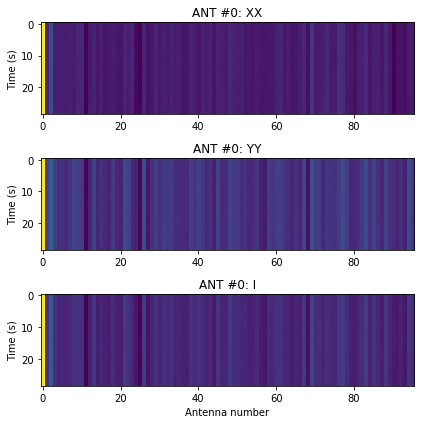

In [16]:
# Check how the various antennas/polarisation look with time
fig1, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(6,6))

ax0.imshow(cube_xx[:, 0, :].real, aspect='auto')
ax0.set_ylabel('Time (s)')
ax0.set_title('ANT #0: XX')
ax1.imshow(cube_yy[:,0,:].real,aspect='auto')
ax1.set_title('ANT #0: YY')
ax1.set_ylabel('Time (s)')
ax2.imshow(visibilities_all[:,0,:].real,aspect='auto')
ax2.set_title('ANT #0: I')
ax2.set_xlabel('Antenna number')
ax2.set_ylabel('Time (s)')
plt.tight_layout()

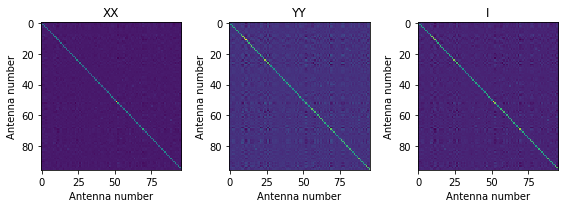

In [17]:
# Check how the correlations look
fig1, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8,3))

ax0.imshow(cube_xx[0,:,:].real, aspect='auto')
ax0.set_xlabel('Antenna number')
ax0.set_ylabel('Antenna number')
ax0.set_title('XX')
ax1.imshow(cube_yy[0,:,:].real, aspect='auto')
ax1.set_title('YY')
ax1.set_xlabel('Antenna number')
ax1.set_ylabel('Antenna number')
ax2.imshow(visibilities.real, aspect='auto')
ax2.set_title('I')
ax2.set_xlabel('Antenna number')
ax2.set_ylabel('Antenna number')
plt.tight_layout()

In [18]:
# Setup the database
db = LofarAntennaDatabase()

In [19]:
# Get the PQR positions for an individual station
station_pqr = db.antenna_pqr(station)

# Exception: for Dutch stations (sparse not yet accommodated)
if (stype == 'core' or stype == 'remote') and atype == 'inner':
    station_pqr = station_pqr[0:48,:]
elif (stype == 'core' or stype == 'remote') and atype == 'outer':
    station_pqr = station_pqr[48:,:]

station_pqr = station_pqr.astype('float32')

In [20]:
# For every antenna, calculate the distance between it and every other antenna
baselines = station_pqr[:, np.newaxis, :] - station_pqr[np.newaxis, :, :]

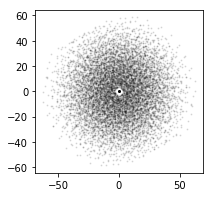

In [21]:
# Make a plot of the baselines contents (only U-V, not W)
# This gives the instantaneous U-V coverage of the LBA station
plt.figure(figsize=(3,3))
plt.scatter(baselines[:,:,0], baselines[:,:,1], facecolor='k', edgecolor='k', s=1, alpha=0.1);

In [22]:
# Account for the rotation
rotation = np.rad2deg(db.rotation_from_north(station))
print ('Rotation for %s: %.2f deg' % (station,rotation))

Rotation for DE603LBA: 3.84 deg


In [23]:
# Make a sky image, by numerically Fourier-transforming from visibilities to image plane
from matplotlib.patches import Circle

# Fourier transform, and account for the rotation (rotation is positive in this space)
# visibilities = cube_xx[2,:,:]
img = sky_imager(visibilities, baselines, freq, npix_l, npix_m)
img = ndimage.interpolation.rotate(img, -rotation, reshape=False, mode='constant', cval=np.nan)

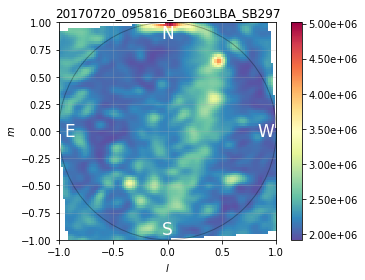

In [24]:
# Plot the resulting sky image
fig, ax = plt.subplots(1)
cimg = ax.imshow(img, origin='lower', cmap=cm.Spectral_r, extent=(-1,1,-1,1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2, axes_class=maxes.Axes)
fig.colorbar(cimg, cax=cax, orientation="vertical", format="%.2e")

circle1 = Circle((0,0), 1.0, edgecolor='k', fill=False, alpha=0.3)
ax.add_artist(circle1)

# Labels
ax.set_xlabel('$l$')
ax.set_ylabel('$m$')
#ax.set_title('\_'.join(fname.split('_'))) # Only for fancy fonts
ax.set_title(fname)

# Plot the compass directions
ax.text(0.9, 0, 'W', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)
ax.text(-0.9, 0, 'E', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)
ax.text(0, 0.9, 'N', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)
ax.text(0, -0.9, 'S', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)

ax.grid(True, alpha=0.3)

plt.savefig(f'results/{fname}_sky_calibrated.png', bbox_inches='tight', dpi=200)

Determine extent to image: we need to image a PQ-rectangle which contains the specified XY extent (in the 'localnorth' coordinate frame sharing the origin with the PQ system but with up pointing North, and tangent to the WGS84 ellipsoid).

In [25]:
from shapely import affinity, geometry

def extent_from_shapely(minx, miny, maxx, maxy):
    return minx, maxx, miny, maxy

def extent_to_shapely(minx, maxx, miny, maxy):
    return minx, miny, maxx, maxy

In [26]:
to_plot_xyz = affinity.rotate(
    affinity.rotate(
        geometry.box(*extent_to_shapely(*extent)),
        rotation, origin=(0,0)).envelope,
    -rotation, origin=(0,0))

To illustrate what we're imaging: the upright box is the extent specfied, the tilted box is the PQ-region that will be imaged.

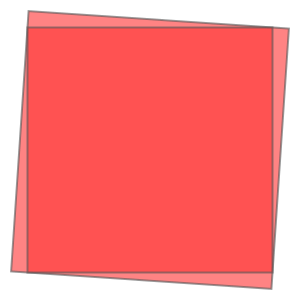

In [27]:
geometry.MultiPolygon([
    to_plot_xyz,
    geometry.box(*extent_to_shapely(*extent))
])

In [28]:
to_plot_pqr = db.pqr_to_localnorth(station)[:2,:2].T @ (np.asarray(to_plot_xyz.exterior.coords[:4])).T
extent_pqr = (np.min(to_plot_pqr[0,:]), np.max(to_plot_pqr[0,:]), np.min(to_plot_pqr[1,:]), np.max(to_plot_pqr[1,:]))

In [29]:
npix_p, npix_q = int(ground_resolution*(extent[1]-extent[0])), int(ground_resolution*(extent[3]-extent[2]))

In [30]:
img = ground_imager(visibilities, baselines, freq, npix_p, npix_q, extent_pqr, station_pqr, height=height)
img_rotated = ndimage.interpolation.rotate(img, rotation, mode='constant', cval=np.nan)

In [31]:
outer_extent_xyz = extent_from_shapely(*(to_plot_xyz.envelope.bounds)) # Extent in xyz coordinates of the rotated image.

In [32]:
import lofargeotiff

In [33]:
# Convert bottom left and upper right to PQR just for lofargeo
pmin, qmin, _ = db.pqr_to_localnorth(station).T @ (np.array([extent[0], extent[2], 0]))
pmax, qmax, _ = db.pqr_to_localnorth(station).T @ (np.array([extent[1], extent[3], 0]))
lon_center, lat_center, _ = lofargeotiff.pqr_to_longlatheight([0,0,0], station)
lon_min, lat_min, _ = lofargeotiff.pqr_to_longlatheight([pmin, qmin, 0], station)
lon_max, lat_max, _ = lofargeotiff.pqr_to_longlatheight([pmax, qmax, 0], station)

# Convert bottom left and upper right to PQR just for lofargeo
outer_pmin, outer_qmin, _ = db.pqr_to_localnorth(station).T @ (np.array([outer_extent_xyz[0], outer_extent_xyz[2], 0]))
outer_pmax, outer_qmax, _ = db.pqr_to_localnorth(station).T @ (np.array([outer_extent_xyz[1], outer_extent_xyz[3], 0]))
outer_lon_min, outer_lat_min, _ = lofargeotiff.pqr_to_longlatheight([pmin, qmin, 0], station)
outer_lon_max, outer_lat_max, _ = lofargeotiff.pqr_to_longlatheight([pmax, qmax, 0], station)

In [34]:
background_image = get_background_image(lon_min, lon_max, lat_min, lat_max, 19)

In [35]:
# Make colors semi-transparent in the lower quarter of the scale
cmap = cm.Spectral_r
cmap_with_alpha = cmap(np.arange(cmap.N))
cmap_with_alpha[:,-1] = np.clip(np.linspace(0, 4, cmap.N), 0., 1.)
cmap_with_alpha = ListedColormap(cmap_with_alpha)

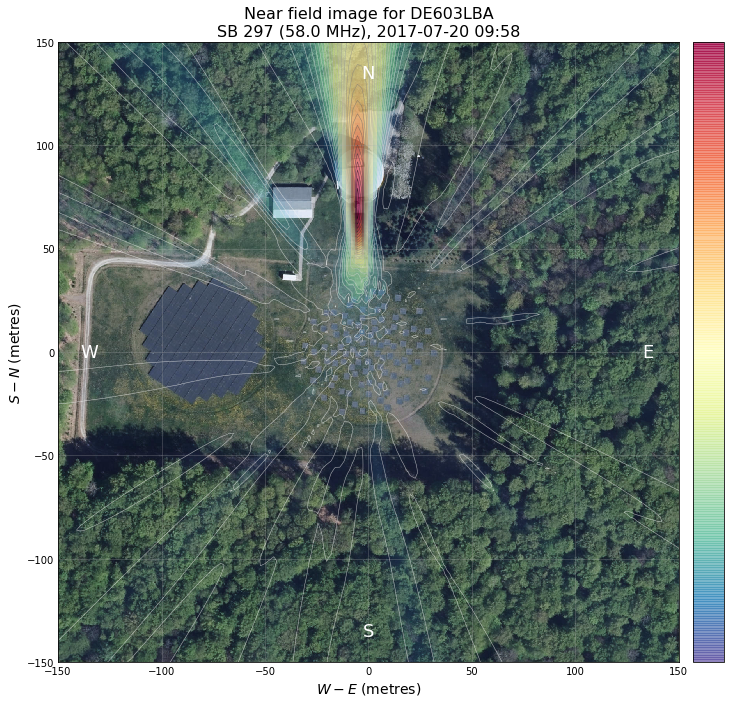

In [36]:
# Plot the resulting image
fig = plt.figure(figsize=(10,10), constrained_layout=True)
ax = fig.add_subplot(111, ymargin=-0.4)
ax.imshow(background_image, extent=extent)
cimg = ax.imshow(img_rotated, origin='lower', cmap=cmap_with_alpha, extent=outer_extent_xyz, alpha=0.7)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2, axes_class=maxes.Axes)
cbar = fig.colorbar(cimg, cax=cax, orientation="vertical")
cbar.set_ticks([])

ax.set_xlabel('$W-E$ (metres)', fontsize=14)
ax.set_ylabel('$S-N$ (metres)', fontsize=14)

ax.set_title(f"Near field image for {station}\nSB {subband} ({freq/1e6:.1f} MHz), {str(obsdate)[:16]}", fontsize=16)

# Change limits to match the original specified extent in the localnorth frame
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.tick_params(axis='both', which='both', length=0)

# Place the NSEW coordinate directions
ax.text(0.95, 0.5, 'E', color='w', fontsize=18, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.05, 0.5, 'W', color='w', fontsize=18, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.5, 0.95, 'N', color='w', fontsize=18, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.5, 0.05, 'S', color='w', fontsize=18, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')

ax.contour(img_rotated, 30, origin='lower', cmap=cm.Greys, extent=outer_extent_xyz, linewidths=0.5, alpha=0.7)
ax.grid(True, alpha=0.3)
plt.savefig(f"results/{fname}_nearfield_calibrated.png", bbox_inches='tight', dpi=200)

In [37]:
plt.imsave(f"results/{fname}_nearfield_calibrated_noaxes.png", img_rotated,
           cmap=cmap_with_alpha, origin='lower')

In [38]:
# Check total time to run
end1 = time.time()
print ('Time elapsed: %.2f s' % (end1-start1))

Time elapsed: 39.29 s


Export the near field image to GeoTIFF for archiving and viewing in other tools (QGIS).

In [39]:
obsdate = datetime.datetime.strptime(obsdatestr + ":" + obstime, '%Y%m%d:%H%M%S')

In [40]:
tags = {"datafile": cubefile,
        "generated_with": "LOFAR LBA imaging tutorial v1.4",
        "caltable": caltable_filename}
lofargeotiff.write_geotiff(img_rotated, f"results/{fname}_nearfield_calibrated.tiff",
                           (outer_pmin, outer_qmin), (outer_pmax, outer_qmax), stationname=station,
                           obsdate=obsdate, tags={"Caltable": caltable_filename,
                                                  "Cubefile": cubefile})

Overlay the near field image on a map.

In [41]:
import folium

In [43]:
m = folium.Map(location=[lat_center, lon_center], zoom_start=19,
               tiles='http://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/MapServer/tile/{z}/{y}/{x}',
               attr='ESRI')
folium.TileLayer(tiles="OpenStreetMap").add_to(m)

folium.raster_layers.ImageOverlay(
   name='Near field image',
   image=f"results/{fname}_nearfield_calibrated_noaxes.png",
   bounds=[[outer_lat_min, outer_lon_min], [outer_lat_max, outer_lon_max]],
   opacity=0.6,
   interactive=True,
   cross_origin=False,
   zindex=1
).add_to(m)

folium.LayerControl().add_to(m)
m